In [1]:
import copy
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit.primitives import BackendEstimator
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima, FakeSherbrooke, FakeLimaV2, FakeWashington
from qiskit import QuantumCircuit, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
real_backend = provider.get_backend('ibm_sherbrooke')

In [4]:
fake_backend = FakeSherbrooke()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='extended_stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [5]:
from qiskit.circuit import Parameter

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_100q_paper_Clifford(self):
            self['nq'] = 100
            self['h'] = 0.5*np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_100q_paper_nonClifford(self):
            self['nq'] = 100
            self['h'] = 0.66*np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_6q_paper(self):
            self['nq'] = 6
            self['h'] = np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, num_steps, measure_basis):
        ops['measure_basis'] = measure_basis
        ops['depth'] = num_steps
        qc = cls.make_quantum_circuit(ops)
        qc.metadata = {}
        qc.metadata['measure_basis'] = measure_basis
        qc.metadata['depth'] = num_steps
        return qc

In [6]:
brisbane_layout = list(range(113, 127)) + [112] + list(range(108, 93, -1)) + [90] + list(range(75, 90)) + [74] + list(range(70, 55, -1)) + [52] + list(range(37, 44)) + [34] + list(range(24, 17, -1)) + [14] + list(range(0, 13)) + [17, 30, 31, 32, 36, 51, 50, 49]

print(len(brisbane_layout))

100


In [15]:
from qiskit.transpiler.passes import RemoveBarriers
def construct_ising_circuit_100q_Clifford(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_100q_paper_Clifford()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

def construct_ising_circuit_100q_nonClifford(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_100q_paper_nonClifford()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

In [25]:
def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

def get_Js(num_Js, num_q):
    np.random.seed(42)
    if num_q == 100:
        h = np.pi * 0.66
    else:
        raise NotImplementedError
    return np.random.uniform(0, h, size=num_Js)

from pec_runtime.utils.stratify import stratify_circuit_into_layers
from pec_runtime.circuit import TwirledCircuit

def construct_random_ising_sameJ_twirled_nonCliff_func(J, be, num_q, num_steps, num_twirl=2):
    basis = 'Z'
    if num_q == 100:
        random_ising = construct_ising_circuit_100q_nonClifford(J, basis, num_steps)
    else:
        raise NotImplementedError

    random_ising.remove_final_measurements()
    layers = stratify_circuit_into_layers(random_ising, twirled_qubits=list(range(num_q)))
    twirled_body = TwirledCircuit(layers, barriers=True)
    random_ising_list = twirled_body.sample_circuits(num_samples=num_twirl)

    ranges_to_remove = [(i, i+6) for i in range(1, 100, 8)]
    random_ising_list_opt = []
    for circuit in random_ising_list:
        new_circuit = QuantumCircuit(*circuit.qregs)
        barrier_count = 0
        for op, qubits, _ in circuit.data:
            if op.name == 'barrier':
                barrier_count += 1
                if any(start <= barrier_count <= end for start, end in ranges_to_remove):
                    continue
            new_circuit.append(op, qubits)
        random_ising_list_opt.append(new_circuit)

    for i in range(len(random_ising_list_opt)):
        random_ising_list_opt[i].measure_all()

    trans_circuits = transpile(
        random_ising_list_opt,
        backend=be,
        optimization_level=3,
        initial_layout=brisbane_layout,
    )
    return trans_circuits, J

def construct_random_ising_sameJ_twirled_Cliff_func(be, num_q, num_steps, num_twirl=2):
    basis = 'Z'
    if num_q == 100:
        random_ising = construct_ising_circuit_100q_Clifford(0, basis, num_steps)
    else:
        raise NotImplementedError

    random_ising.remove_final_measurements()
    layers = stratify_circuit_into_layers(random_ising, twirled_qubits=list(range(num_q)))
    twirled_body = TwirledCircuit(layers, barriers=True)
    random_ising_list = twirled_body.sample_circuits(num_samples=num_twirl)

    ranges_to_remove = [(i, i+6) for i in range(1, 100, 8)]
    random_ising_list_opt = []
    for circuit in random_ising_list:
        new_circuit = QuantumCircuit(*circuit.qregs)
        barrier_count = 0
        for op, qubits, _ in circuit.data:
            if op.name == 'barrier':
                barrier_count += 1
                if any(start <= barrier_count <= end for start, end in ranges_to_remove):
                    continue
            new_circuit.append(op, qubits)
        random_ising_list_opt.append(new_circuit)

    for i in range(len(random_ising_list_opt)):
        random_ising_list_opt[i].measure_all()

    trans_circuits = transpile(
        random_ising_list_opt,
        backend=be,
        optimization_level=3,
        initial_layout=brisbane_layout,
    )
    return trans_circuits, J

In [ ]:
with open('./data/ising_zne_hardware/98q_sherbrooke_sameJ_h0.66pi/step_01.pk', 'rb') as file:
    loaded = pickle.load(file)

circ = loaded[1]['circuit']
circ.remove_final_measurements()
circ.draw(**D)

In [54]:
import os
from tqdm.notebook import tqdm
def load_circuits(data_dir, filename, f_ext='.pk'):
    circuits_twirled = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    J = []
    data_files = sorted([os.path.join(data_dir, f) for f in [filename]])
    for data_file in data_files:
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits_twirled.append(entry['circuit_twirled'])
                J.append(entry['J'])
                # ideal_exp_vals.append(entry['ideal_exp_value'])
                # noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits_twirled, J #, ideal_exp_vals, noisy_exp_vals

circuits_twirled, J = load_circuits('./data/ising_zne_hardware_twirled/100q_brisbane', 'step_01_J00.pk')

In [19]:
circuits_twirled

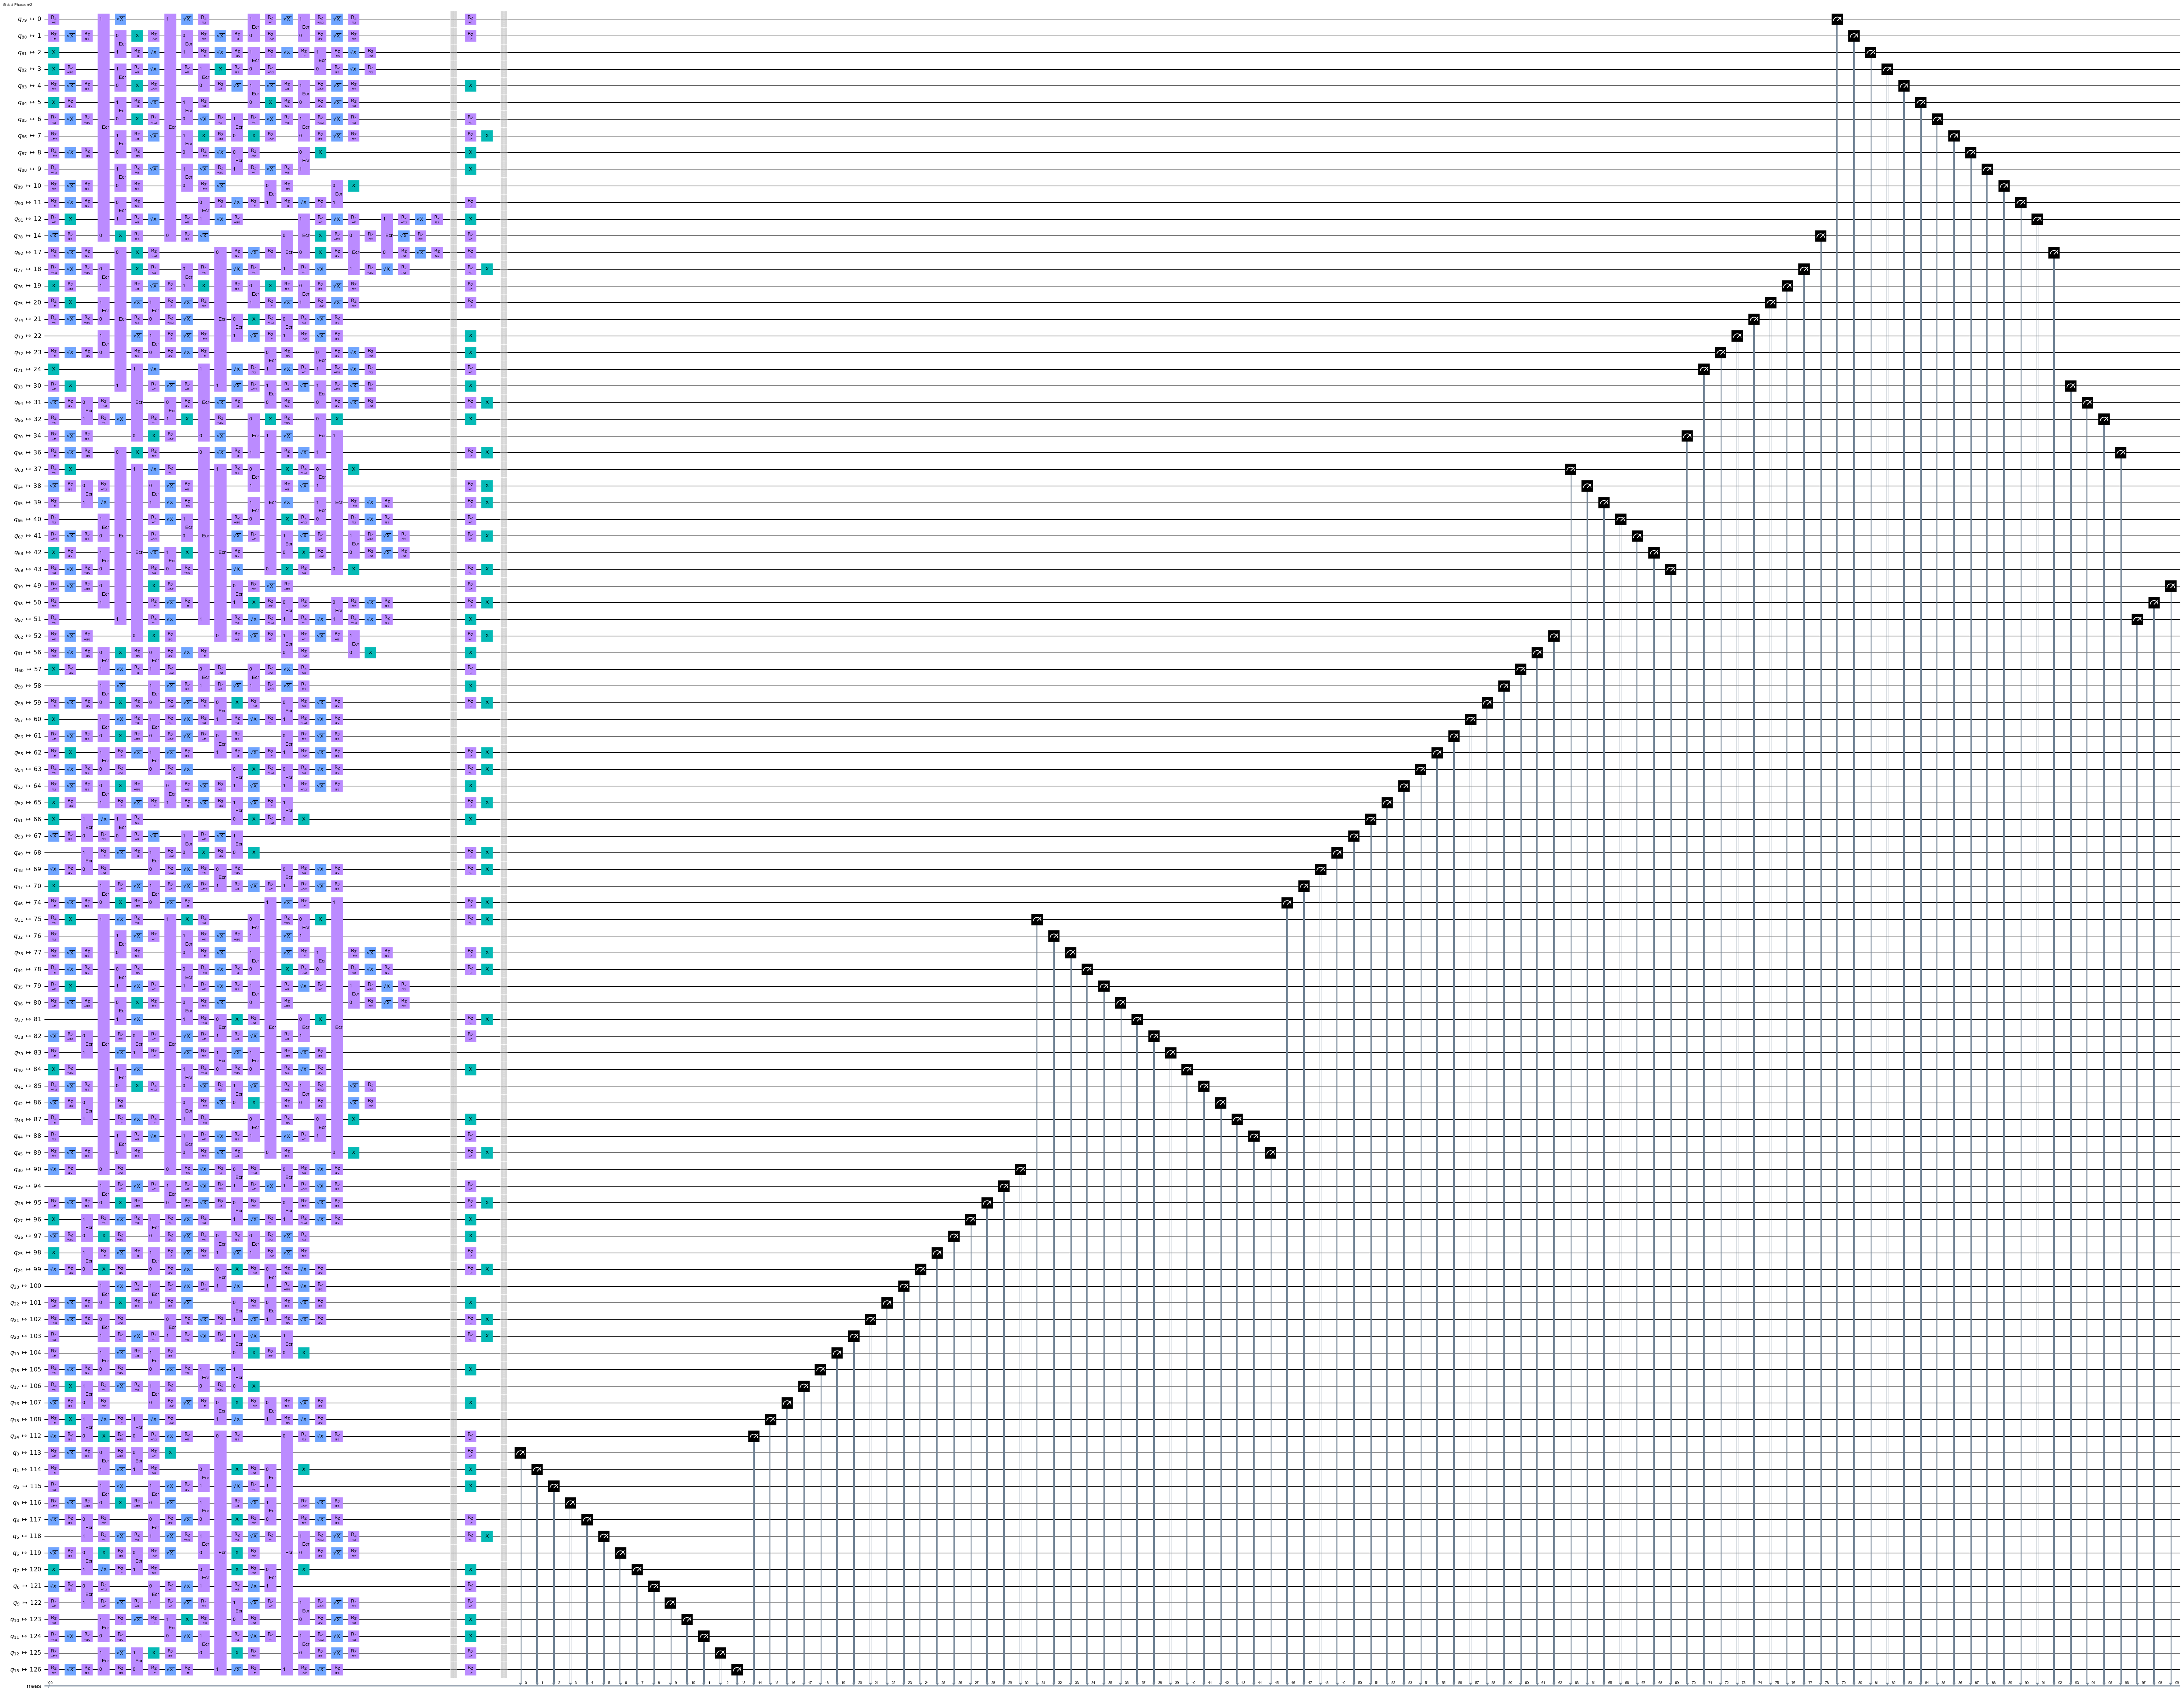

In [20]:
# train_circuits[61].remove_final_measurements()
circuits_twirled[1].draw(**D)

In [40]:
circuits_twirled, J = load_circuits('./data/ising_zne_hardware_twirled/100q_brisbane', 'step_01_J00.pk')

obs_list = ['I'*5+'Z'+'I'*94, 'I'*45+'Z'+'I'*54, 'I'*60+'Z'+'I'*39, 'I'*74+'Z'+'I'*25, 'I'*88+'Z'+'I'*11]
padded_obs_all_circs = []
for trans_circuit in circuits_twirled:
    padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]

  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
print([126-padded_obs_all_circs[i].paulis.to_labels()[0].find('Z') for i in range(10, 15)])

[118, 89, 57, 21, 9]


In [128]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
options = Options()
options.resilience_level = 2
options.optimization_level = 0
options.execution.shots = 10000
options.resilience.noise_factors = (1, 3)
options.resilience.noise_amplifier = 'TwoQubitAmplifier'
options.resilience.extrapolator = 'LinearExtrapolator'
service = QiskitRuntimeService()

In [133]:
runtime_estimator = RuntimeEstimator(session=Session(service=service, backend="ibm_brisbane"), options=options)

In [134]:
num_twirls = 5
obs_list = ['I'*5+'Z'+'I'*94,
            'I'*45+'Z'+'I'*54,
            'I'*60+'Z'+'I'*39,
            'I'*74+'Z'+'I'*25,
            'I'*88+'Z'+'I'*11]

step_index = 10
for J_index in range(50):
    circuits_twirled, J = load_circuits(
        './data/ising_zne_hardware_twirled/100q_brisbane/circuits',
        'step_%02d_J%02d.pk'%(step_index, J_index)
    )
    assert len(circuits_twirled) == num_twirls
    padded_obs_all_circs = []
    for trans_circuit in circuits_twirled:
        padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]

    circs_to_submit = []
    for circ in circuits_twirled:
        circ.remove_final_measurements()
        circs_to_submit.extend([circ]*len(obs_list))

    job = runtime_estimator.run(
        circuits=circs_to_submit,
        observables=padded_obs_all_circs
    )

    to_save = dict()
    to_save['job_id'] = job.job_id()
    to_save['J_index'] = J_index
    to_save['step_index'] = step_index
    print(J_index, job.job_id(), len(circ_to_submit))

    with open('./data/ising_zne_hardware_twirled/100q_brisbane/job_ids/step_%02d_J%02d.json'%(step_index, J_index), 'w') as file:
        json.dump(to_save, file)

0 ci34r21cinbchsikt380 5
1 ci34r3m1o26hu33t81ig 5
2 ci34r5ekcccjrh2jfm40 5
3 ci34r6ukcccjrh2jfn9g 5
4 ci34r8ukcccjrh2jfog0 5
5 ci34ra93lqnvrkq81ek0 5
6 ci34rc0ihcilpv7tkthg 5
7 ci34re1cinbchsiktb50 5
8 ci34rfqlnlj7iib0icog 5
9 ci34rhe1o26hu33t8amg 5
10 ci34rj1cinbchsikte7g 5
11 ci34rkukcccjrh2jg1i0 5
12 ci34rm8ihcilpv7tl4ig 5
13 ci34romkcccjrh2jg4jg 5
14 ci34rr13lqnvrkq81r90 5
15 ci34rt8ihcilpv7tla00 5
16 ci34rupcinbchsiktn10 5
17 ci34s0m1o26hu33t8ku0 5
18 ci34s22lnlj7iib0io50 5
19 ci34s3oihcilpv7tle9g 5
20 ci34s5h3lqnvrkq822r0 5
21 ci34s79cinbchsikts20 5
22 ci34s8oihcilpv7tlhj0 5
23 ci34sbm1o26hu33t8si0 5
24 ci34se61o26hu33t8ub0 5
25 ci34sfoihcilpv7tlm90 5
26 ci34shgihcilpv7tlnlg 5
27 ci34sjekcccjrh2jgnbg 5
28 ci34sl13lqnvrkq82e00 5
29 ci34smilnlj7iib0j75g 5
30 ci34som1o26hu33t9650 5
31 ci34sq93lqnvrkq82hm0 5
32 ci34srpcinbchsikua80 5
33 ci34sth3lqnvrkq82k80 5
34 ci34sv93lqnvrkq82le0 5
35 ci34t16kcccjrh2jh1j0 5
36 ci34t2u1o26hu33t9d6g 5
37 ci34t4ilnlj7iib0jg3g 5
38 ci34t68ihcilpv7tm6a

# Resubmission

In [135]:
import os
from tqdm.notebook import tqdm

def check_f(f, f_ext, step_indices):
    return f.endswith(f_ext) and any([f"step_%02d"%step_index in f for step_index in step_indices])

def check_status(data_dir, step_indices, f_ext='.json'):
    callback = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        loaded = json.load(open(data_file, 'r'))
        job_status = service.job(loaded['job_id']).status()
        step_index = loaded['step_index']
        J_index = loaded['J_index']
        print(step_index, J_index, job_status)
        if job_status.name == 'ERROR':
            callback.append([step_index, J_index, job_status])
    print('-'*50)
    for x, y, z in callback: print(x, y, z)

check_status('./data/ising_zne_hardware_twirled/100q_brisbane/job_ids/', [10])

  0%|          | 0/50 [00:00<?, ?it/s]

10 0 JobStatus.DONE
10 1 JobStatus.DONE
10 2 JobStatus.DONE
10 3 JobStatus.DONE
10 4 JobStatus.DONE
10 5 JobStatus.DONE
10 6 JobStatus.DONE
10 7 JobStatus.DONE
10 8 JobStatus.DONE
10 9 JobStatus.DONE
10 10 JobStatus.DONE
10 11 JobStatus.DONE
10 12 JobStatus.DONE
10 13 JobStatus.DONE
10 14 JobStatus.DONE
10 15 JobStatus.DONE
10 16 JobStatus.DONE
10 17 JobStatus.DONE
10 18 JobStatus.DONE
10 19 JobStatus.DONE
10 20 JobStatus.DONE
10 21 JobStatus.DONE
10 22 JobStatus.DONE
10 23 JobStatus.DONE
10 24 JobStatus.DONE
10 25 JobStatus.DONE
10 26 JobStatus.DONE
10 27 JobStatus.DONE
10 28 JobStatus.DONE
10 29 JobStatus.DONE
10 30 JobStatus.DONE
10 31 JobStatus.DONE
10 32 JobStatus.DONE
10 33 JobStatus.DONE
10 34 JobStatus.DONE
10 35 JobStatus.DONE
10 36 JobStatus.DONE
10 37 JobStatus.DONE
10 38 JobStatus.DONE
10 39 JobStatus.DONE
10 40 JobStatus.DONE
10 41 JobStatus.ERROR
10 42 JobStatus.DONE
10 43 JobStatus.DONE
10 44 JobStatus.DONE
10 45 JobStatus.DONE
10 46 JobStatus.DONE
10 47 JobStatus.DONE
1

In [137]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
options = Options()
options.resilience_level = 2
options.optimization_level = 0
options.execution.shots = 10000
options.resilience.noise_factors = (1, 3)
options.resilience.noise_amplifier = 'TwoQubitAmplifier'
options.resilience.extrapolator = 'LinearExtrapolator'
service = QiskitRuntimeService()

In [138]:
runtime_estimator = RuntimeEstimator(session=Session(service=service, backend="ibm_brisbane"), options=options)

In [139]:
num_twirls = 5
obs_list = ['I'*5+'Z'+'I'*94,
            'I'*45+'Z'+'I'*54,
            'I'*60+'Z'+'I'*39,
            'I'*74+'Z'+'I'*25,
            'I'*88+'Z'+'I'*11]

step_index = 10
for J_index in [41]:
    circuits_twirled, J = load_circuits(
        './data/ising_zne_hardware_twirled/100q_brisbane/circuits',
        'step_%02d_J%02d.pk'%(step_index, J_index)
    )
    assert len(circuits_twirled) == num_twirls
    padded_obs_all_circs = []
    for trans_circuit in circuits_twirled:
        padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]

    circs_to_submit = []
    for circ in circuits_twirled:
        circ.remove_final_measurements()
        circs_to_submit.extend([circ]*len(obs_list))

    job = runtime_estimator.run(
        circuits=circs_to_submit,
        observables=padded_obs_all_circs
    )

    to_save = dict()
    to_save['job_id'] = job.job_id()
    to_save['J_index'] = J_index
    to_save['step_index'] = step_index
    print(J_index, job.job_id(), len(circ_to_submit))

    with open('./data/ising_zne_hardware_twirled/100q_brisbane/job_ids/step_%02d_J%02d.json'%(step_index, J_index), 'w') as file:
        json.dump(to_save, file)

41 ci3ib9tejm3lf1c48rr0 5
